<a href="https://colab.research.google.com/github/sungjindo/Traffic-prediction/blob/main/Traffic_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset



In [ ]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam
from google.colab import drive
import datetime as dt
from datetime import timedelta
import seaborn as sns
# from prophet import Prophet


from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object

import matplotlib.pyplot as plt
DATASET_PATH = os.path.join('/content/gdrive/MyDrive/글창사 traffic/data')
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
## EDA
train=pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))

val=pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))

test=pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))


In [ ]:
#index 날짜화 for feature
def datesetting(train): 
    train['날짜1']=train['날짜'].astype(str)
    train['시간1']=train['시간'].astype(str)
    train['date']=train['날짜']+train['시간']

    for i in range (0,len(train['날짜'])):
      a= train['날짜1'][i]
      train['날짜1'][i] =dt.datetime.strptime(a, '%Y%m%d')

    for i in range(0,len(train['시간'])):
      b= train['시간1'][i]
      train['시간1'][i]=dt.datetime.strptime(b, '%H')

    for i in range(0,len(train['날짜'])):
      train['date'][i]=train['날짜1'][i]+timedelta(hours=train['시간1'][i].hour)


#날짜 index 적용
datesetting(train)
datesetting(val)
datesetting(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train=train.drop(['날짜1','시간1'],axis=1)
val=val.drop(['날짜1','시간1'],axis=1)
test=test.drop(['날짜1','시간1'],axis=1)


# index 설정하여 각 기간별 columns 생성하는 함수(create_features)
train=train.set_index('date')
val=val.set_index('date')
test=test.set_index('date')
# test=test[test.index >= '2020-05-25']
df= pd.concat([train,val])
# def create_features(df):
#     """
#     Create time series features based on time series index.
#     """
#     df = df.copy()
#     df['hour'] = df.index.hour
#     df['dayofweek'] = df.index.dayofweek
#     df['quarter'] = df.index.quarter
#     df['month'] = df.index.month
#     df['year'] = df.index.year
#     df['dayofyear'] = df.index.dayofyear
#     df['dayofmonth'] = df.index.day
#     # df['weekofyear'] = df.index.isocalendar().week   UIint32 형으로 출력되어 삭제함.
#     return df

## Model

In [ ]:
# from torch.autograd import Variable

# class RNN(nn.Module):
#   def __init__(self, input_size, hidden_size, output_size):  # init 함수는 2개의 선형레이어를 초기화 한다. 하나는 출력, 다른 하나는 상태 벡터 또는 히든 벡터를 계산한다.
#     super(RNN, self).__init__()
#     self.hidden_size = hidden_size
#     self.i2h =  nn.Linear(input_size + hidden_size, hidden_size)
#     self.i2o =  nn.Linear(input_size + hidden_size, hidden_size)
#     self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self,input, hidden):   #forward 함수는 입력 벡터와 히든 벡터를 cat함수로 결합해 출력벡터와 숨겨진 상태를 생성하는 두 선형 레이어를 통과시킨다. 
#       combined = torch.cat((input, hidden), 1)
#       hidden = self.i2h(combined)
#       output = self.i2o(combined)
#       output = self.softmax(output)   # 출력 layer에는 log_softmax함수를 적용.
#       return output, hidden

#     def initHidden(self):   # RNN을 처음 호출할 경우에 상태 벡터를 만드는 기능을 제공한다.
#       return Variable(torch.zeros(1, self.hidden_size))

# # torch.cat은 두 텐서를 결합하며, 두 번째 전달 인자인 dim은 결합방향을 설정했다. 예를 들어 input이 [[1,1,],[2,2,]]이고 hidden이 [[11,11],[22,22]]라면, torch.cat((input,hidden),1)의 결과는 [[1,1,1,11,11],[2,2,22,22]]이 된다.


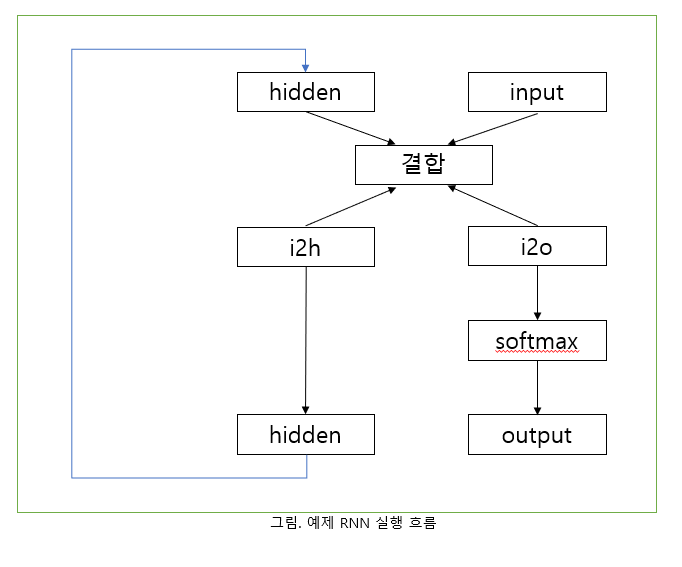

#Generating dataset

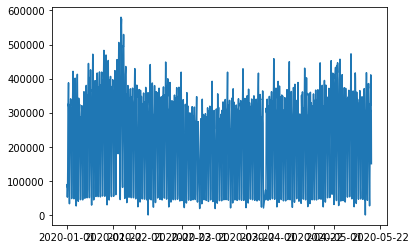

In [ ]:
plt.plot(train['10'])

In [ ]:
len(train.index)

3279

In [ ]:
train['10'].shape

(3279,)

In [ ]:
seq_len = 10 #sequence의 길이를 설정하는 부분 10 -> 10시간 기준
X = []
y_true = []
for i in range(len(train.index)-seq_len): #seq_len을 기준 데이터 만들어줍니다.
  X.append(train['10'][i:i+seq_len])
  y_true.append(train['10'][i+seq_len])


X = np.array(X)
y = np.array(y_true)
print(y.shape) #길이가 3269
print(X.shape)
# 원래는 얘네를 permutation해서 랜덤으로 섞어줘야한다.
# lstm이나 rnn 차원 맞추는 방법은 [seq_len, batch_size, input_dim] 처음이 seq_len인 이유는 for문을 돌리기가 쉽다. 
# 각각의 time step에 대해  batch_size와 input_dim을 가져오는 형태


# [10, 2390,1]으로 바꾸기 위해선
X = np.swapaxes(X,0,1)    
X = np.expand_dims(X, axis = 2)

for x in X:
  print(x.shape)
  break



(3269,)
(3269, 10)
(3269, 1)


In [ ]:
len(train['10'])

3279

In [ ]:
X.shape

(10, 3269, 1)

In [ ]:
print(x.shape)
print(y.shape)

(3269, 1)
(3269,)


#Model define

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_dim, output_dim, hid_dim, batch_size):
    super(RNN, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hid_dim = hid_dim
    self.batch_size = batch_size

    self.u = nn.Linear(self.input_dim, self.hid_dim, bias = False)
    self.w = nn.Linear(self.hid_dim, self.hid_dim, bias = False)
    self.v = nn.Linear(self.hid_dim, self.output_dim, bias = False)
    self.act = nn.Tanh()
    
    self.hidden = self.init_hidden()
  
  def init_hidden(self, batch_size=None):
    if batch_size is None :
      batch_size = self.batch_size
    return torch.zeros(batch_size, self.hid_dim)
  
  def forward(self, x):
    h = self.act(self.u(x) + self.w(self.hidden))
    y = self.v(h)
    
    return y, h


#Train Trigonometric Function

In [ ]:
from torch import optim
model = RNN(1, 1, 50, 3269)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
epoch = 100

for i in range(epoch):
  model.train()   #모델을 train 시키는 부분 epoch 내에서
  model.zero_grad() 
  optimizer.zero_grad()  

  model.hidden = model.init_hidden()

  for x in X:
    x = torch.Tensor(x).float()
    y_true = torch.Tensor(y_true).float()

    y_pred, hidden = model(x)
    model.hidden = hidden
  loss = loss_fn(y_pred.view(-1), y_true.view(-1))
  loss.backward()
  optimizer.step()
  print(loss.item())

68726661120.0
28366880768.0
18234400768.0
15699253248.0
15065965568.0
14907599872.0
14867997696.0
14858092544.0
14855617536.0
14854998016.0
14854844416.0
14854805504.0
14854794240.0
14854793216.0
14854791168.0
14854791168.0
14854791168.0
14854791168.0
14854790144.0
14854774784.0
14854557696.0
14854556672.0
14854557696.0
14854556672.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854557696.0
14854429696.0
14854428672.0
14854428672.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
14854429696.0
148544

In [ ]:
print(len(x))
print(len(y))

3269
3269


In [ ]:
X.shape

(10, 3269, 1)

In [ ]:
np.expand_dims(X[:,1,:],1).shape

(10, 1, 1)

In [ ]:
torch.Tensor(x).float().shape

torch.Size([3269, 1])

In [ ]:
x.shape

torch.Size([3269, 1])

In [ ]:
test_X = np.expand_dims(X[:, 0, :],1)

list_y_pred = []

model.eval()
with torch.no_grad():
  model.hidden = model.init_hidden(batch_size = 1)

for x in test_X:
    x = torch.Tensor(x).float()
    y_pred, hidden = model(x)
    model.hidden = hidden
  list_y_pred.append(y_pred.view(-1).item())
  temp_X = list()
  temp_X += list(np.squeeze(test_X))[1:]
  temp_X.append(y_pred.view(-1).item())

IndentationError: ignored

#Predict Target Function

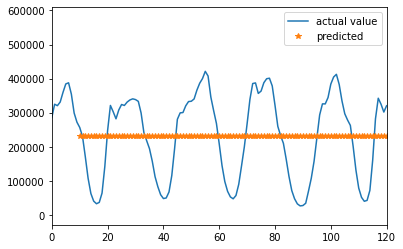

In [ ]:
from matplotlib.transforms import LockableBbox
test_X = np.expand_dims(X[:, 0, :],1)

list_y_pred = []

model.eval()
with torch.no_grad():
  model.hidden = model.init_hidden(batch_size = 1)

  for x in test_X:
    x = torch.Tensor(x).float()
    y_pred, hidden = model(x)
    model.hidden = hidden
  list_y_pred.append(y_pred.view(-1).item())

  temp_X = list()
  temp_X += list(np.squeeze(test_X))[1:]
  temp_X.append(y_pred.view(-1).item())
  for i in range(3268):
    model.hidden = model.init_hidden(batch_size = 1)

    temp2_X = torch.unsqueeze(torch.unsqueeze(torch.Tensor(temp_X),1), 1)
    for x in temp2_X:
      y_pred, hidden = model(x)
      model.hidden = hidden
    list_y_pred.append(y_pred.view(-1).item())

    temp_X.append(y_pred.view(-1).item())
    temp_X.pop(0)

plt.plot(y, label='actual value')
plt.plot(list(range(10, 3279)), list_y_pred, '*', label='predicted')
plt.xlim(0, 120)
plt.legend()





